In [1]:
import os
import csv 
import sys 
import numpy as np
from scipy import sparse
from collections import Counter

try:
    import xml.etree.cElementTree as ET
except ImportError:
    import xml.etree.ElementTree as ET


from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer

import util

/Users/fanxu/anaconda2/envs/my-rdkit-env/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
import csv 
import sys 

def reorder_submission(file_to_reorder, newfile_name = "experiment_results.csv"):
    # READ IN KEYS IN CORRECT ORDER AS LIST
    with open('keys.csv','r') as f:
        keyreader = csv.reader(f)
        keys = [key[0] for key in keyreader]

    # READ IN ALL PREDICTIONS, REGARDLESS OF ORDER
    with open(file_to_reorder) as f:
        oldfile_reader = csv.reader(f)
        D = {}
        for i,row in enumerate(oldfile_reader):
            if i == 0:
                continue
            _id, pred = row 
            D[_id] = pred

    # WRITE PREDICTIONS IN NEW ORDER
    with open(newfile_name,'wb') as f:
        writer = csv.writer(f)
        writer.writerow(('Id','Prediction'))
        for key in keys:
            writer.writerow((key,D[key]))

    print("".join(["Reordered ", file_to_reorder," and wrote to ", newfile_name]))

In [3]:
X_train = sparse.load_npz("X_train.npz")
t_train = np.load("t_train.npy")
train_ids = np.load("train_ids.npy")

In [4]:
print X_train.shape
print train_ids.shape

(3086, 29813)
(3086,)


In [7]:
X_test = sparse.load_npz("X_test.npz")
test_ids = np.load("test_ids.npy")

In [8]:
print X_test.shape
print test_ids.shape

(3724, 29813)
(3724,)


In [10]:
y_train = np.zeros((len(t_train),len(util.malware_classes)))
y_train[np.arange(len(t_train)), t_train] = 1
y_train.shape

(3086, 15)

In [12]:
# X_train_bkup = X_train

In [13]:
# X_test_bkup = X_test

In [20]:
X_train = X_train_bkup
X_test = X_test_bkup

In [21]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, class_weight = "balanced")
RF.fit(X_train, y_train)
scores = cross_val_score(RF, X_train, y_train, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best = RF
score_best = scores.mean()
X_train_best = X_train
X_test_best = X_test

Features: 29813	Accuracy: 0.85839 (+/- 0.02575)


In [22]:
from sklearn.feature_selection import SelectFromModel
while X_train.shape[1] > 1000:
    model = SelectFromModel(RF, prefit=True, threshold = "0.5*mean")
    X_train = model.transform(X_train)
    ## trick: break if we didn't remove any feature
    if X_train.shape[1] == X_test.shape[1]:
        break
    X_test = model.transform(X_test)
    
    RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1, class_weight = "balanced")
    RF.fit(X_train, y_train)
    scores = cross_val_score(RF, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best <= mean_score:
        del X_train_best
        del X_test_best
        RF_best = RF
        score_best = mean_score
        X_train_best = X_train
        X_test_best = X_test

Features: 5222	Accuracy: 0.86260 (+/- 0.02325)
Features: 1779	Accuracy: 0.86131 (+/- 0.02374)
Features: 951	Accuracy: 0.86163 (+/- 0.02617)


In [27]:
for n in [200, 600, 1000, 1400]:
    for f in ['sqrt', 'log2', None]:
        for c in [None, "balanced"]:
            RF = RandomForestClassifier(n_estimators = n, n_jobs = -1, max_features = f, class_weight = c)
            RF.fit(X_train_best, y_train)
            scores = cross_val_score(RF, X_train_best, y_train, cv=5)
            mean_score = scores.mean()
            print str(n)
            print f
            print c
            print ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))

200
sqrt
None
	Accuracy: 0.87719 (+/- 0.02433)
200
sqrt
balanced
	Accuracy: 0.86423 (+/- 0.02333)
200
log2
None
	Accuracy: 0.87330 (+/- 0.02515)
200
log2
balanced
	Accuracy: 0.86293 (+/- 0.02551)
200
None
None
	Accuracy: 0.88172 (+/- 0.01893)
200
None
balanced
	Accuracy: 0.86131 (+/- 0.03184)
600
sqrt
None
	Accuracy: 0.87686 (+/- 0.02268)
600
sqrt
balanced
	Accuracy: 0.86196 (+/- 0.02475)
600
log2
None
	Accuracy: 0.87394 (+/- 0.02433)
600
log2
balanced
	Accuracy: 0.86066 (+/- 0.02461)
600
None
None
	Accuracy: 0.88172 (+/- 0.01752)
600
None
balanced
	Accuracy: 0.86163 (+/- 0.03144)
1000
sqrt
None
	Accuracy: 0.87654 (+/- 0.02416)
1000
sqrt
balanced
	Accuracy: 0.86293 (+/- 0.02449)
1000
log2
None
	Accuracy: 0.87232 (+/- 0.02657)
1000
log2
balanced
	Accuracy: 0.86098 (+/- 0.02500)
1000
None
None
	Accuracy: 0.88108 (+/- 0.01648)
1000
None
balanced
	Accuracy: 0.86098 (+/- 0.02928)
1400
sqrt
None
	Accuracy: 0.87719 (+/- 0.02309)
1400
sqrt
balanced
	Accuracy: 0.86325 (+/- 0.02749)
1400
log2
No

In [31]:
X_train_best.shape

(3086, 5222)

In [32]:
RF = RandomForestClassifier(n_estimators = 1400, n_jobs = -1, max_features = None, class_weight = None)
RF.fit(X_train_best, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

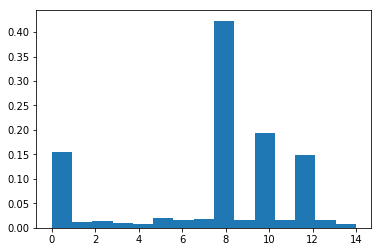

In [33]:
preds = RF.predict(X_test_best)
results = np.argmax(preds, axis=1)
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(results, bins=15, normed = True)
plt.show()

In [34]:
print "writing predictions..."
util.write_predictions(results, test_ids, "test.csv")

reorder_submission("test.csv", "experiment_rf_1400_bNone_results.csv")

writing predictions...
Reordered test.csv and wrote to experiment_rf_1400_bNone_results.csv


In [24]:
preds = RF.predict(X_test)

In [25]:
# TODO make predictions on text data and write them out
print "making predictions..."
results = np.argmax(preds, axis=1)

print "writing predictions..."
util.write_predictions(results, test_ids, "test.csv")

reorder_submission("test.csv", "experiment_rf_results.csv")

making predictions...
writing predictions...
Reordered test.csv and wrote to experiment_rf_results.csv


In [ ]:
X_train = X_train_bkup
X_test = X_test_bkup

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
RF.fit(X_train, y_train)
scores = cross_val_score(RF, X_train, y_train, cv=5)
print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (scores.mean(), scores.std() * 2))
RF_best2 = RF
score_best2 = scores.mean()
X_train_best2 = X_train
X_test_best2 = X_test

In [ ]:
from sklearn.feature_selection import SelectFromModel
while X_train.shape[1] > 1000:
    model = SelectFromModel(RF, prefit=True, threshold = "0.5*mean")
    X_train = model.transform(X_train)
    ## trick: break if we didn't remove any feature
    if X_train.shape[1] == X_test.shape[1]:
        break
    X_test = model.transform(X_test)
    
    RF = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)
    RF.fit(X_train, y_train)
    scores = cross_val_score(RF, X_train, y_train, cv=5)
    mean_score = scores.mean()
    print "Features: " + str(RF.n_features_) + ("\tAccuracy: %0.5f (+/- %0.5f)" % (mean_score, scores.std() * 2))
    
    if score_best2 <= mean_score:
        del X_train_best2
        del X_test_best2
        RF_best2 = RF
        score_best2 = mean_score
        X_train_best2 = X_train
        X_test_best2 = X_test

In [ ]:
import xgboost as xgb